*   Kütüphanelerin eklenmesi



In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

*  **Dataset Oluşturma Aşaması**
*   tf.keras.utils.image_dataset_from_directory() fonksiyonu resimleri değişkenlere yüklemek için kullanılır.
*   her resmi 32'e 32'lik tekrar boyutlandırıyoruz.
*   batch_size : Neural networkin bir seferinde çalışacağı resim sayısı.



In [2]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/trees/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/trees/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/trees/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2347 files belonging to 20 classes.
Found 904 files belonging to 20 classes.
Found 1508 files belonging to 20 classes.


*   Train datasından bazılarını göstermek için yazdırdık. Resimlerin orjinallerinin boyutları farklı olsa bile daha önceden yeniden boyutlandırma yaptığımız için hepsi kare ve 32,32 boyutlarındalar.

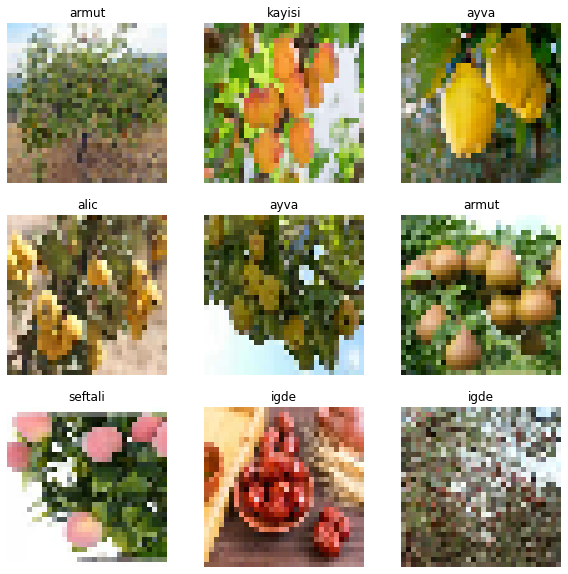

In [3]:
class_names = ["akcaagac","alic", "armut", "ayva","banyan","cam","disbudak","elma","erik","gurgen","igde","kayin","kayisi","kiraz","kizilcik","kusburnu","mese","muz","seftali","visne"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

*   **Model Oluşum Aşaması**
*   tf.keras.Sequential() : neural network katmanlarımızı ekler.
* tf.keras.layers.Rescaling() : her bir resmi rgb değerlerini 0 ile 255 arasında değerlerden 0 ile 1 arasında yeniden düzenlendik. 
* Convolutional layer : tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D() -- 3 defa uyguladık.






In [4]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(20)
    ]
)

Modelin derlenmesi ve loss fonksiyonu

In [5]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

Oluşturulan model train data ve validation data üzerinde epoch sayısı kadar döner ve model eğitilir.


In [6]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30
)

Epoch 1/30
118/118 [==============================] - 479s 4s/step - loss: 2.7286 - accuracy: 0.1393 - val_loss: 2.5489 - val_accuracy: 0.1670
Epoch 2/30
118/118 [==============================] - 11s 86ms/step - loss: 2.1962 - accuracy: 0.2693 - val_loss: 2.1093 - val_accuracy: 0.2588
Epoch 3/30
118/118 [==============================] - 11s 93ms/step - loss: 1.8917 - accuracy: 0.3511 - val_loss: 1.7969 - val_accuracy: 0.4004
Epoch 4/30
118/118 [==============================] - 12s 99ms/step - loss: 1.7606 - accuracy: 0.3937 - val_loss: 1.5974 - val_accuracy: 0.4535
Epoch 5/30
118/118 [==============================] - 11s 88ms/step - loss: 1.5992 - accuracy: 0.4576 - val_loss: 1.4457 - val_accuracy: 0.5177
Epoch 6/30
118/118 [==============================] - 10s 86ms/step - loss: 1.4781 - accuracy: 0.4891 - val_loss: 1.2955 - val_accuracy: 0.5664
Epoch 7/30
118/118 [==============================] - 10s 86ms/step - loss: 1.3990 - accuracy: 0.5232 - val_loss: 1.1626 - val_accuracy: 

Train datası ve validation datası üzerinden eğitilen model, test datası üzerinden değerlendirilir.

In [7]:
model.evaluate(test_ds)

76/76 [==============================] - 161s 2s/step - loss: 0.2861 - accuracy: 0.9072


[0.2860609292984009, 0.9071618318557739]

Test datası üzerinden rastgele alınan resimlerle model tahminde bulunur ve bu resimlerin tahmin edilen sınıfı ve gerçek sınıfı yazdırılır.

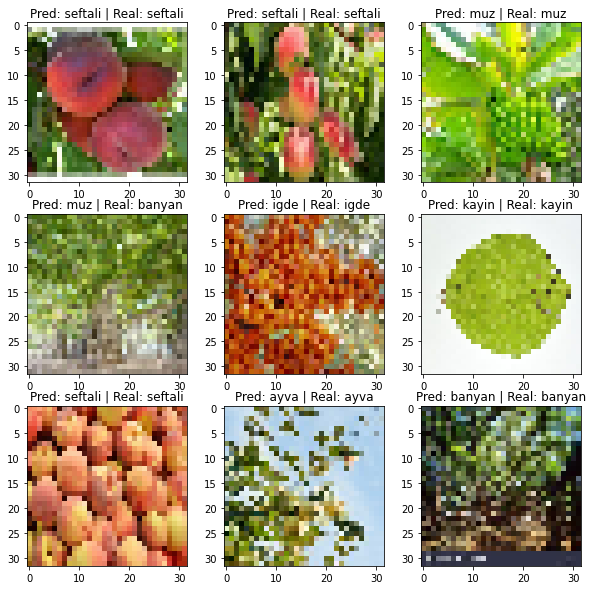

In [8]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)